In [1]:
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.linalg as dense_linalg
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')

# Set up example vector potential and magnetic field

Try sample problem of magnetic field from an infinite wire. 

Since I want to solve Laplace problem I will look at the current free area next to wire.

Set the wire centered at x=+15 and y=0 and radius 1.

### Rectilinear Mesh

In [2]:
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)

mesh = np.meshgrid(x, y)
delta = x[1] - x[0]

In [3]:
x

array([-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
        0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ])

### Analytic A and B field

In [4]:
r = np.sqrt((mesh[0]-15)**2. + mesh[1]**2.)
current = 1.
wire_radius = 1.  
mu_0 = 1.
A_x = np.zeros(mesh[0].shape)
A_y = np.zeros(mesh[0].shape)
A_z = -current*mu_0/(2.*np.pi)*np.log(r/wire_radius) 

theta = np.arctan2(mesh[1], mesh[0] - 15.)
B_x = mu_0*current/(2.*np.pi*r)*np.sin(theta)*-1
B_y = mu_0*current/(2.*np.pi*r)*np.cos(theta)
B_z = np.zeros(mesh[0].shape)

# Check if A_z is Laplace solution

In [5]:
(np.gradient(np.gradient(A_z, axis=1), axis=1)* 1/delta**2
 + np.gradient(np.gradient(A_z, axis=0), axis=0) * 1/delta**2)

array([[  3.78408661e-06,   8.46437714e-05,   1.81734572e-04,
          1.97242229e-04,   2.13550178e-04,   2.29995808e-04,
          2.45260986e-04,   2.56853555e-04,   6.96519273e-05,
         -1.54067179e-04],
       [ -7.44829747e-05,   5.42383109e-06,   1.04132818e-04,
          1.15177607e-04,   1.27635743e-04,   1.41528377e-04,
          1.56661900e-04,   1.72366636e-04,  -6.80167678e-05,
         -3.75297234e-04],
       [ -1.64200242e-04,  -8.90864975e-05,   6.10264209e-06,
          7.61454965e-06,   9.58648864e-06,   1.21707149e-05,
          1.55563493e-05,   1.99437905e-05,  -2.92019911e-04,
         -7.13089774e-04],
       [ -1.69168574e-04,  -9.18599801e-05,   7.19833369e-06,
          9.20321707e-06,   1.19441864e-05,   1.57624513e-05,
          2.11920169e-05,   2.90874118e-05,  -3.27209497e-04,
         -8.30881789e-04],
       [ -1.71707372e-04,  -9.32731463e-05,   7.79272749e-06,
          1.00747247e-05,   1.32553234e-05,   1.77938494e-05,
          2.44478452e-05

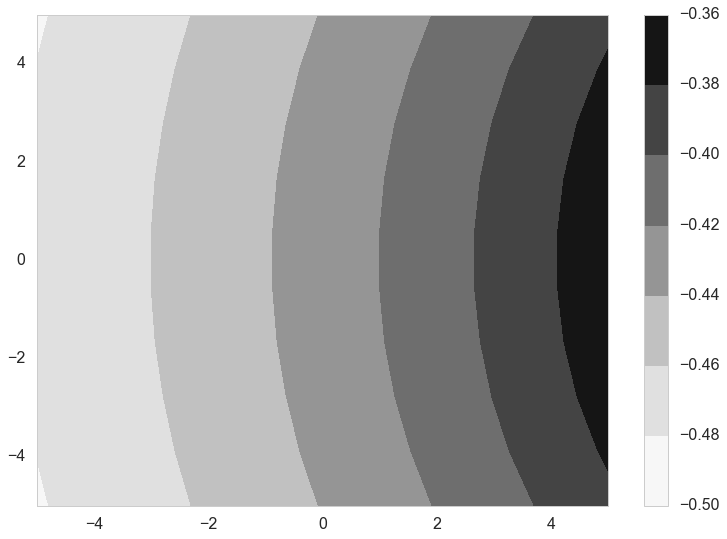

In [6]:
plt.contourf(mesh[0][:,:], mesh[1][:,:], A_z[:,:])
plt.colorbar()

### Plot of B field

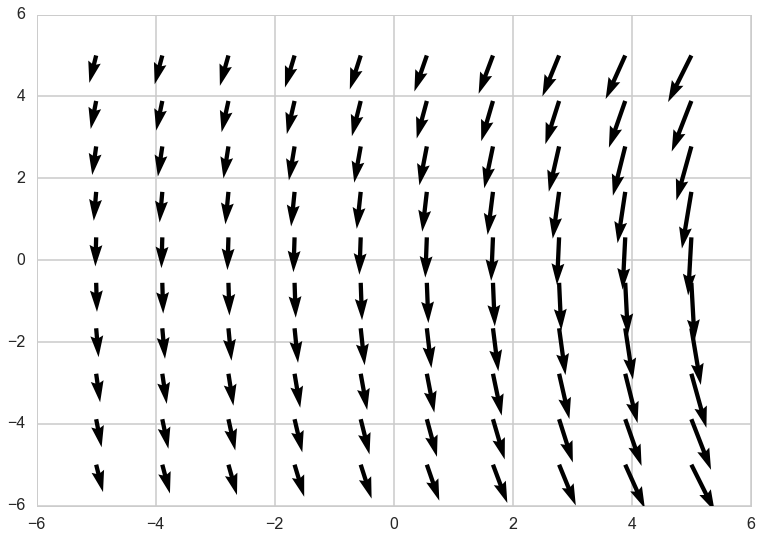

In [7]:
plt.quiver(mesh[0][:,:], mesh[1][:,:], B_x[:,:], B_y[:,:])

### Plot of B field from curl of A

In [8]:
def curl(vector, delta):
    vector_x_dx = np.gradient(vector[0], axis=1)*1./delta
    vector_x_dy = np.gradient(vector[0], axis=0)*1./delta
    
    vector_y_dx = np.gradient(vector[1], axis=1)*1./delta
    vector_y_dy = np.gradient(vector[1], axis=0)*1./delta
    
    vector_z_dx = np.gradient(vector[2], axis=1)*1./delta
    vector_z_dy = np.gradient(vector[2], axis=0)*1./delta
    
    curl_x = vector_z_dy
    curl_y = -vector_z_dx
    curl_z = vector_y_dx - vector_x_dy
    
    return [curl_x, curl_y, curl_z]

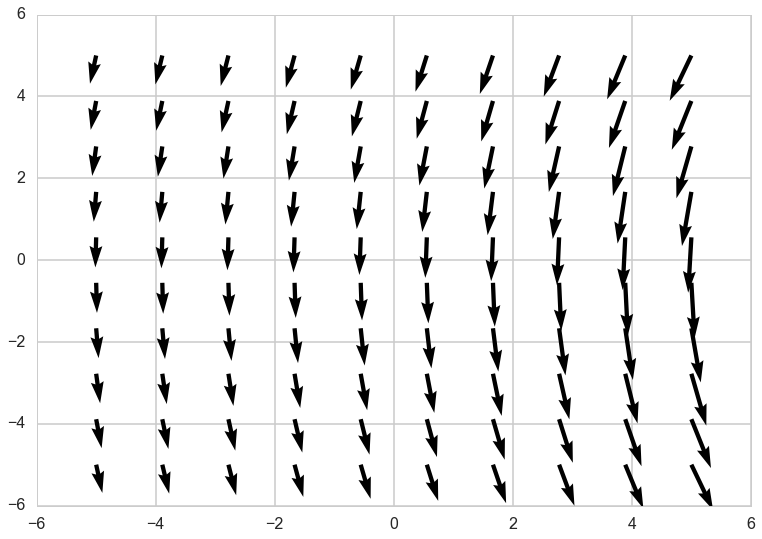

In [9]:
B_from_curl = curl([A_x, A_y, A_z], delta)
plt.quiver(mesh[0][:,:], mesh[1][:,:], B_from_curl[0][:,:], B_from_curl[1][:,:])

# Solve for A by solving Laplace equation

### Set up Laplace problem with Dirichlet boundaries

Build the matrix and b vector for the $Ax=b$ problem.

In [10]:
b_vector = np.zeros(A_z[1:-1, 1:-1].shape)
b_vector[0, :] += -A_z[0, 1:-1]
b_vector[:, 0] += -A_z[1:-1, 0]
b_vector[-1, :] += -A_z[-1, 1:-1]
b_vector[:, -1] += -A_z[1:-1, -1]
b_vector = b_vector.ravel()

In [11]:
b_vector

array([ 0.95281664,  0.46409799,  0.45462603,  0.44461176,  0.43399881,
        0.42272434,  0.41071942,  0.77558583,  0.47830604,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.37238267,  0.47733631,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.36864814,  0.47684698,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.36671303,  0.47684698,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.36671303,
        0.47733631,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.36864814,  0.47830604,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.37238267,  0.95281664,  0.46409799,  0.45462603,  0.44461176,
        0.43399881,  0.42272434,  0.41071942,  0.77558583])

In [12]:
shape = mesh[0][1:-1,1:-1].shape
shape_x = x[1:-1].shape
matrix_x = sparse.diags((-2, 1, 1), (0, -1, 1), shape=(shape_x[0], shape_x[0]))
shape_y = y[1:-1].shape
matrix_y = sparse.diags((-2, 1, 1), (0, -1, 1), shape=(shape_y[0], shape_y[0]))
matrix = sparse.kronsum(matrix_x, matrix_y)

In [13]:
matrix.toarray()

array([[-4.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -4.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -4., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ..., -4.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -4.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -4.]])

# Check matrix rank and condition number

In [14]:
np.linalg.cond(matrix.toarray())

32.163437477526351

In [15]:
1/(np.finfo(x.dtype).eps)

4503599627370496.0

In [16]:
np.linalg.matrix_rank(matrix.toarray())

64

In [17]:
matrix.toarray().shape

(64, 64)

In [18]:
b_vector.shape

(64,)

In [19]:
mesh[0].shape

(10, 10)

### Solve linear algebra equation 

In [20]:
solution = dense_linalg.solve(matrix.toarray(), b_vector)
solution = solution.reshape(shape)

In [21]:
A_z_solved = np.array(A_z)
A_z_solved[1:-1, 1:-1] = solution

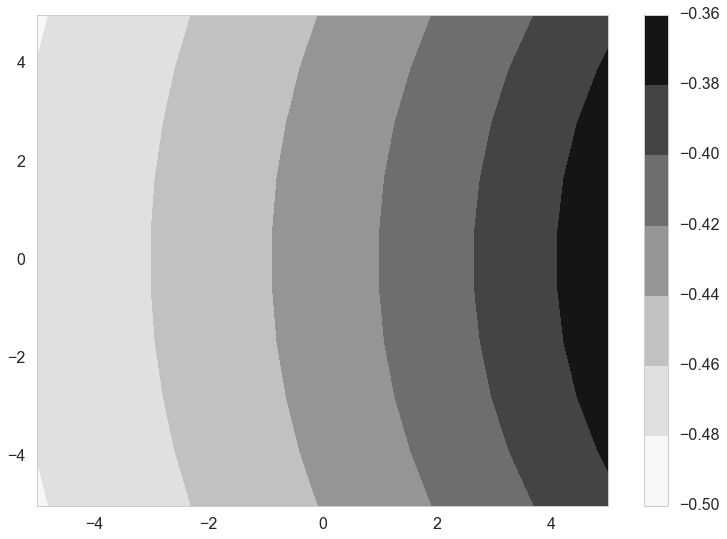

In [22]:
plt.contourf(mesh[0][:,:], mesh[1][:,:], A_z_solved[:,:])
plt.colorbar()

### Test if curl of solution recovers B

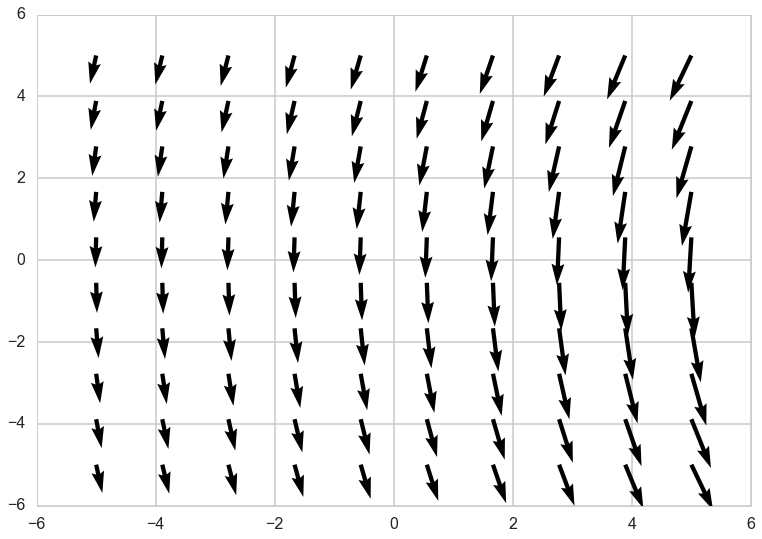

In [23]:
B_solved = curl([A_x, A_y, A_z_solved], delta)
plt.quiver(mesh[0], mesh[1], B_solved[0], B_solved[1])

# Now repeat with Neuman boundary conditions

Build the matrix and b vector for the $Ax=b$ problem.

In [24]:
b_vector = np.zeros(B_x.shape)
b_vector[0, :] += 1./delta*B_y[0, :]
b_vector[:, 0] += 1./delta*B_x[:, 0]
b_vector[-1, :] += -1./delta*B_y[-1, :]
b_vector[:, -1] += -1./delta*B_x[:, -1]
b_vector = b_vector.ravel()

In [62]:
shape = mesh[0].shape[1]
matrix_x = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape, shape))

for i, offset in enumerate(matrix_x.offsets):
    if offset == 0:
        matrix_x.data[i, offset] = -1.
        matrix_x.data[i, -1] = -1
    if offset < 0:
        matrix_x.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_x.data[i, offset] = 1.
matrix_x = matrix_x*1./delta**2.

shape = mesh[0].shape[0]
matrix_y = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape, shape))

for i, offset in enumerate(matrix_y.offsets):
    if offset == 0:
        matrix_y.data[i, offset] = -1.        
        matrix_y.data[i, -1] = -1
    if offset < 0:
        matrix_y.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_y.data[i, offset] = 1.
matrix_y = matrix_y*1./delta**2.


matrix = (sparse.kron(sparse.eye(matrix_y.shape[0]), matrix_x) +
          sparse.kron(matrix_y, sparse.eye(matrix_x.shape[0])))

In [63]:
matrix.toarray()

array([[-2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -3.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -3., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ..., -3.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -3.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -2.]])

In [64]:
matrix_x.toarray()

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.]])

In [65]:
matrix_y.toarray()

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.]])

## The matrix is singular

In [66]:
matrix.shape

(100, 100)

In [67]:
np.linalg.matrix_rank(matrix.toarray())

99

In [68]:
np.linalg.cond(matrix.toarray())

41050092799315840.0

# Tie down a single point

In [69]:
matrix_tie_down = sparse.csr_matrix(matrix)
matrix_tie_down.data[matrix.indptr[0]:matrix.indptr[1]] = [1, 0, 0]
b_vector_tie_down = np.array(b_vector)
b_vector_tie_down[0] = 0

In [70]:
np.linalg.matrix_rank(matrix_tie_down.toarray())

100

In [71]:
np.linalg.cond(matrix_tie_down.toarray())

1043.6314105286344

## Solve Laplace 

In [72]:
shape = mesh[0].shape
solution = dense_linalg.solve(matrix_tie_down.toarray(), b_vector_tie_down)
solution = solution.reshape(shape)

In [73]:
scalar_potential = np.array(solution)
B_x_solved_neumann = np.gradient(scalar_potential, axis=1)*1./(delta)
B_y_solved_neumann = np.gradient(scalar_potential, axis=0)*1./(delta)

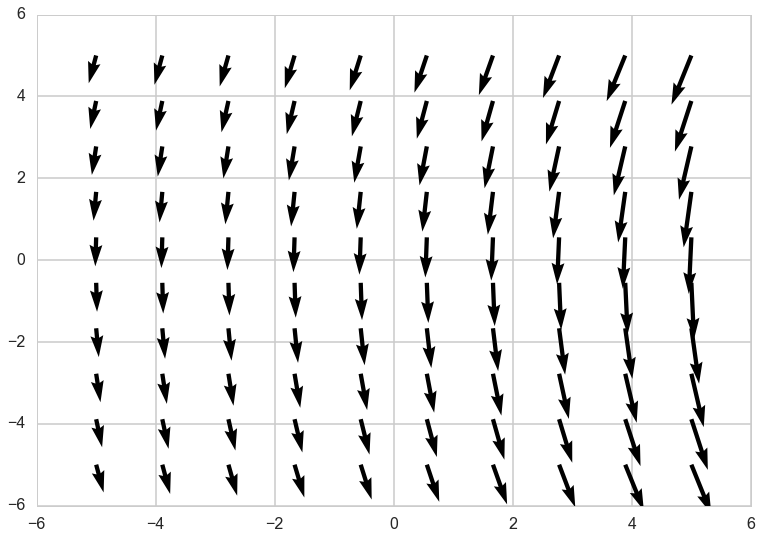

In [74]:
plt.quiver(mesh[0][:,:], mesh[1][:,:], 
           B_x_solved_neumann[:,:], 
           B_y_solved_neumann[:,:])

# Contour plots of the individual components look different too 

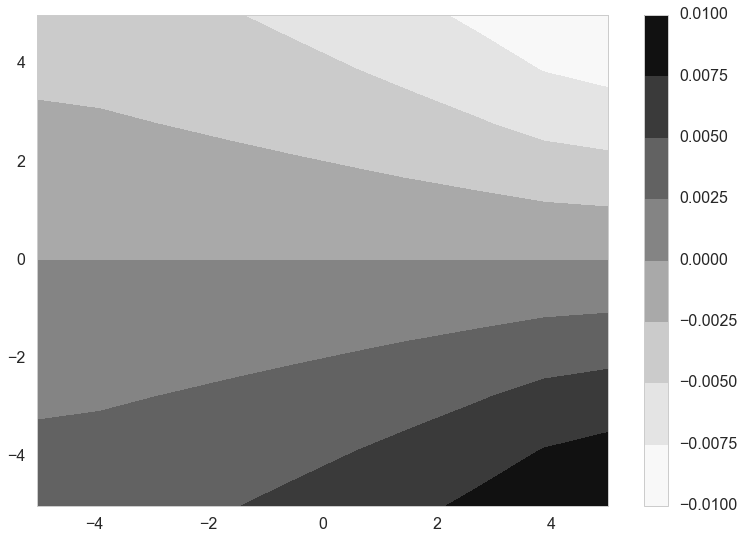

In [75]:
plt.contourf(mesh[0][:,:], mesh[1][:,:], B_x_solved_neumann[:,:])
plt.colorbar()

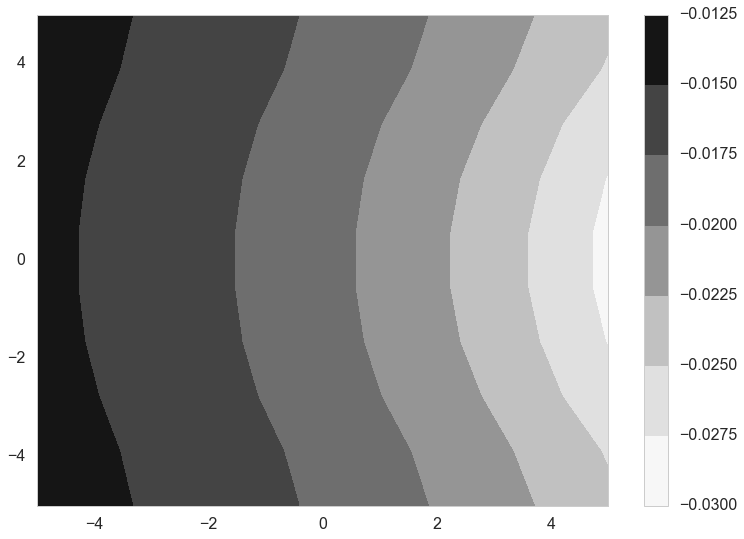

In [76]:
plt.contourf(mesh[0][:,:], mesh[1][:,:], B_y_solved_neumann[:,:])
plt.colorbar()

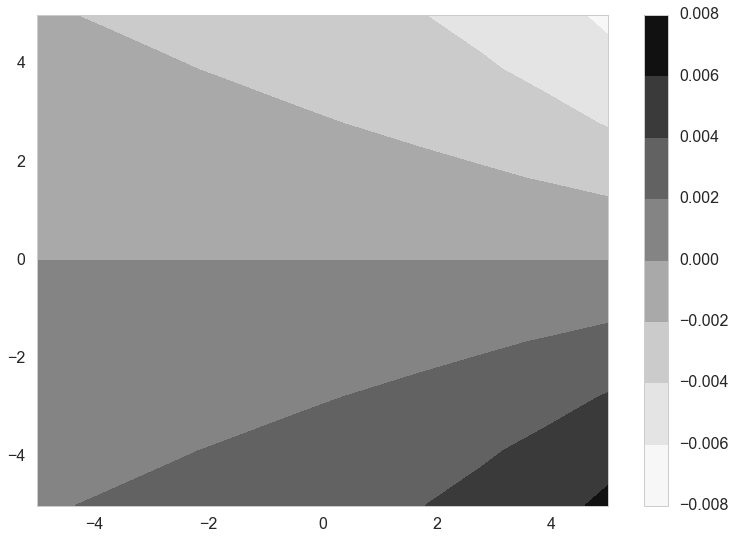

In [77]:
plt.contourf(mesh[0][:,:], mesh[1][:,:], B_x[:,:])
plt.colorbar()

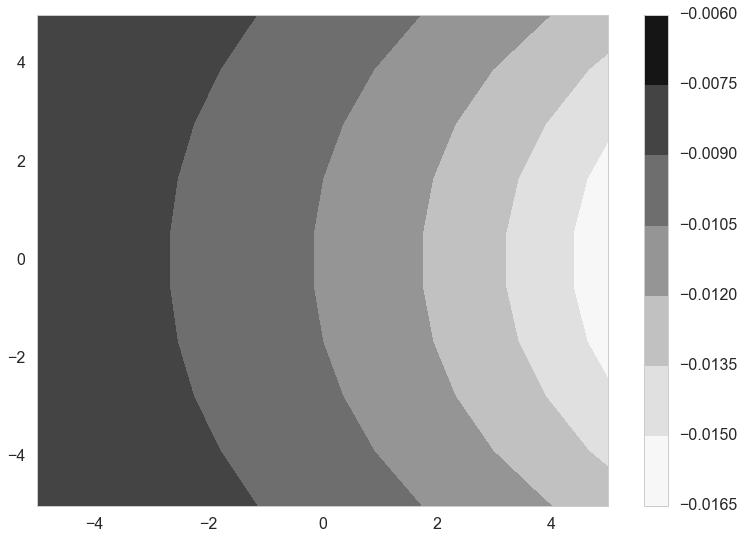

In [78]:
plt.contourf(mesh[0][:,:], mesh[1][:,:], B_y[:,:])
plt.colorbar()

# Different  x, y shapes

In [144]:
x = np.linspace(-5, 5, 30)
y = np.linspace(-5, 5, 20)

mesh = np.meshgrid(x, y)
delta_x = x[1] - x[0]
delta_y = y[1] - y[0]

r = np.sqrt((mesh[0]-15)**2. + mesh[1]**2.)
current = 1.
wire_radius = 1.  
mu_0 = 1.
A_x = np.zeros(mesh[0].shape)
A_y = np.zeros(mesh[0].shape)
A_z = -current*mu_0/(2.*np.pi)*np.log(r/wire_radius) 

theta = np.arctan2(mesh[1], mesh[0] - 15.)
B_x = mu_0*current/(2.*np.pi*r)*np.sin(theta)*-1
B_y = mu_0*current/(2.*np.pi*r)*np.cos(theta)
B_z = np.zeros(mesh[0].shape)

In [145]:
b_vector = np.zeros(B_x.shape)
b_vector[0, :] += 1./delta*B_y[0, :]
b_vector[:, 0] += 1./delta*B_x[:, 0]
b_vector[-1, :] += -1./delta*B_y[-1, :]
b_vector[:, -1] += -1./delta*B_x[:, -1]
b_vector = b_vector.ravel()

In [146]:
shape = mesh[0].shape[1]
matrix_x = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape, shape))

for i, offset in enumerate(matrix_x.offsets):
    if offset == 0:
        matrix_x.data[i, offset] = -1.
        matrix_x.data[i, -1] = -1
    if offset < 0:
        matrix_x.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_x.data[i, offset] = 1.
matrix_x = matrix_x*1./delta**2.

shape = mesh[0].shape[0]
matrix_y = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape, shape))

for i, offset in enumerate(matrix_y.offsets):
    if offset == 0:
        matrix_y.data[i, offset] = -1.        
        matrix_y.data[i, -1] = -1
    if offset < 0:
        matrix_y.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_y.data[i, offset] = 1.
matrix_y = matrix_y*1./delta**2.


matrix = (sparse.kron(sparse.eye(matrix_y.shape[0]), matrix_x) +
          sparse.kron(matrix_y, sparse.eye(matrix_x.shape[0])))

In [147]:
matrix.toarray()

array([[-2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -3.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -3., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ..., -3.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -3.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -2.]])

In [148]:
matrix_tie_down = sparse.csr_matrix(matrix)
matrix_tie_down.data[matrix.indptr[0]] = 1
matrix_tie_down.data[matrix.indptr[0]+1:matrix.indptr[1]] = 0
b_vector_tie_down = np.array(b_vector)
b_vector_tie_down[0] = 0

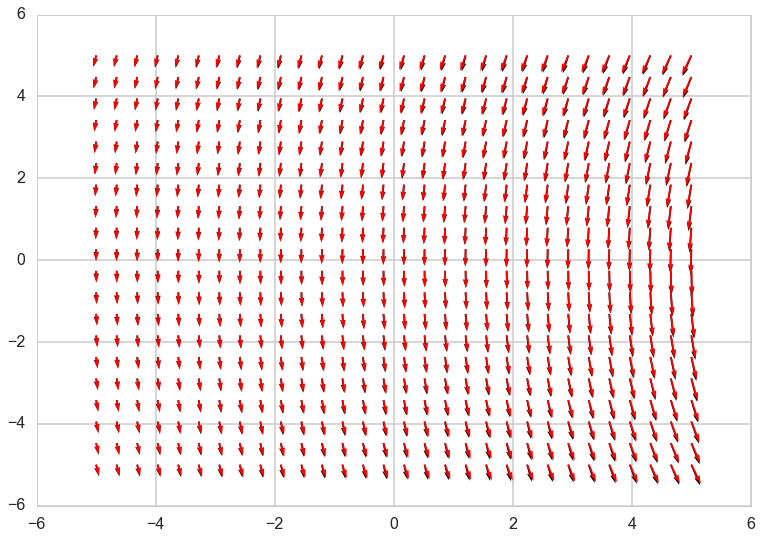

In [149]:
shape = mesh[0].shape
solution = dense_linalg.solve(matrix_tie_down.toarray(), b_vector_tie_down)
solution = solution.reshape(shape)
scalar_potential = np.array(solution)
B_x_solved_neumann = np.gradient(scalar_potential, axis=1)*1./(delta)
B_y_solved_neumann = np.gradient(scalar_potential, axis=0)*1./(delta)
plt.quiver(mesh[0][:,:], mesh[1][:,:], 
           B_x_solved_neumann[:,:], 
           B_y_solved_neumann[:,:])
plt.quiver(mesh[0][:,:], mesh[1][:,:], 
           B_x[:,:], 
           B_y[:,:], color='red')

# Test Matrix

In [79]:
delta = 1
shape = 3
matrix_x = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape, shape))

for i, offset in enumerate(matrix_x.offsets):
    if offset == 0:
        matrix_x.data[i, offset] = -1.
        matrix_x.data[i, -1] = -1
    if offset < 0:
        matrix_x.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_x.data[i, offset] = 1.
matrix_x = matrix_x*1./delta**2.

shape = 3
matrix_y = sparse.diags((-2, 1, 1), (0, -1, 1), 
                        shape=(shape, shape))

for i, offset in enumerate(matrix_y.offsets):
    if offset == 0:
        matrix_y.data[i, offset] = -1.        
        matrix_y.data[i, -1] = -1
    if offset < 0:
        matrix_y.data[i, offset-1] = 1.
    elif offset > 0:
        matrix_y.data[i, offset] = 1.
matrix_y = matrix_y*1./delta**2.


matrix = (sparse.kron(sparse.eye(matrix_y.shape[0]), matrix_x) +
          sparse.kron(matrix_y, sparse.eye(matrix_x.shape[0])))

In [80]:
matrix.toarray()

array([[-2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -3.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0., -3.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  1., -4.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  1., -3.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.,  0., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  1., -3.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -2.]])

In [81]:
matrix_x.toarray()

array([[-1.,  1.,  0.],
       [ 1., -2.,  1.],
       [ 0.,  1., -1.]])

In [82]:
matrix_y.toarray()

array([[-1.,  1.,  0.],
       [ 1., -2.,  1.],
       [ 0.,  1., -1.]])